In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 200
LR = 1e-5 
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_2"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling_2"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.5 # initial vdl weight
OUT_SHAPE = IN_SHAPE*MAGNIFICATION*N_MAG

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def alpha_delta_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../Simulations/data_model_2/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../Simulations/data_model_2/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../Simulations/data_model_2/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Models and physics-inspired loss function loading

In [5]:
# We construct and load the SISR models to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, out_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)
alpha_delta_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, out_channels=1, latent_channel_count=config["latent_channels"]).to(device)
classifier = models.Classifier(in_shape=OUT_SHAPE, out_classes=3, model=2, in_channels=1).to(device)
classifier_criterion = torch.nn.CrossEntropyLoss()

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
opt_classifier = torch.optim.Adam(params=list(classifier.parameters())+list(alpha_delta_model.parameters()),lr=LR)

alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}x2")

classifier_params = sum(p.numel() for p in classifier.parameters())
print(f"Classifier network parameters: {classifier_params}")

Image network parameters: 899843x2
Classifier network parameters: 736475


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

In [7]:
classifier.apply(init_weights)

Classifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (b1): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b3): Sequential(
    (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), 

### Defining functions that sample the model's performance

In [8]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i][0].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha_r = alpha_model(LR.to(device))
    alpha_r = alpha_scaling(alpha_r)
    alpha_delta = alpha_delta_model(LR.to(device))
    alpha_delta = alpha_delta_scaling(alpha_delta)
    sersic_profile, LR, source_profile = lens_loss.get_sample((alpha_r+alpha_delta).to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


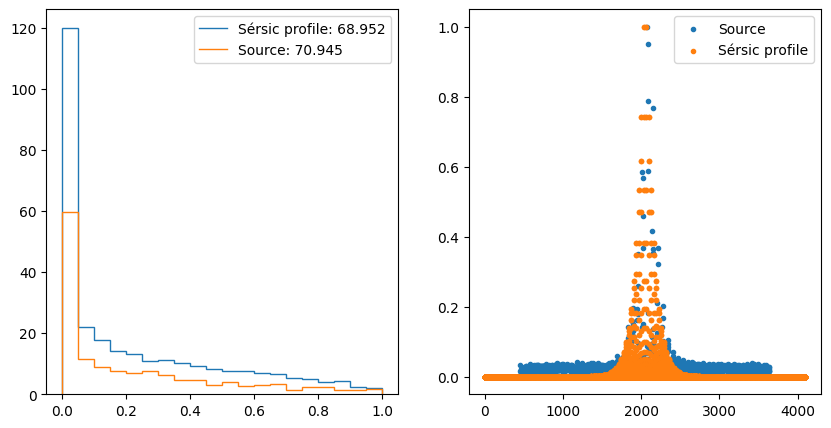

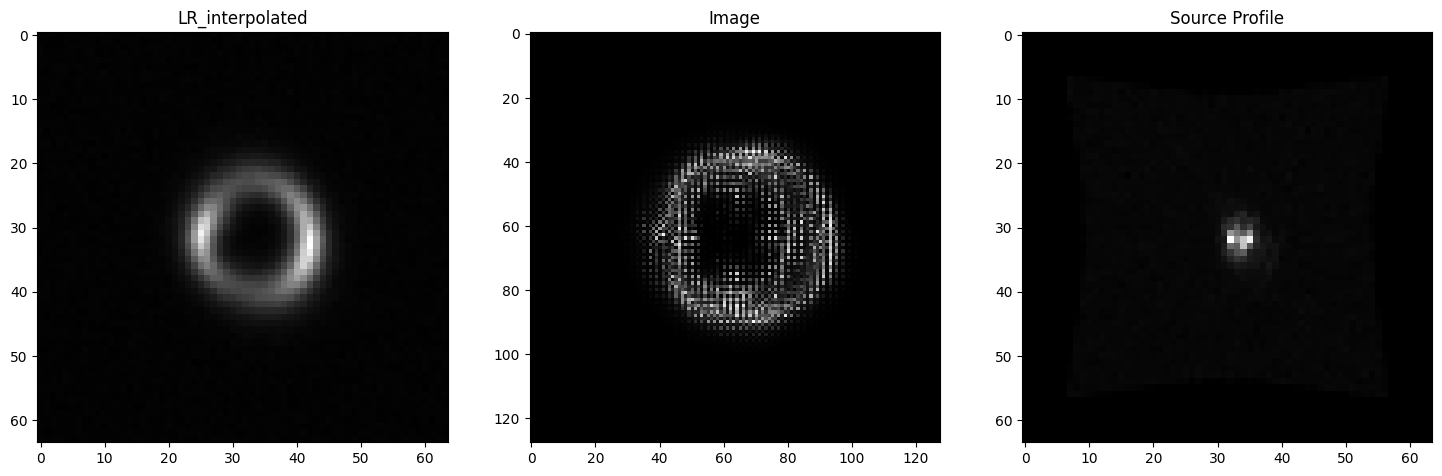

In [9]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required.

In [10]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
best_delta_weights = None
history = {'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'c_loss':[], 'c_val_loss':[], 'accs':[], 'val_accs':[]} # tracks the train and val losses and training results at each epoch
for epoch in range(EPOCHS):
    losses = []
    classifier_losses = []
    accs = []
    alpha_model.train()
    alpha_delta_model.train()
    classifier.train()
    for i,(x, label) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, label) = (x.float().to(device), label.to(device))
        alpha_r = alpha_model(x)
        alpha_r = alpha_scaling(alpha_r)
        alpha_delta = alpha_delta_model(x)
        alpha_delta = alpha_delta_scaling(alpha_delta)
        loss = lens_loss(alpha_r, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        class_prediction = classifier(alpha_delta)
        classifier_loss = classifier_criterion(class_prediction, label)
        I_lens, _, _ = lens_loss.get_sample(alpha_r.detach() + alpha_delta, x, plot=False)
        LR_interpolated = torch.nn.functional.interpolate(x, scale_factor = 2, mode='bicubic')
        classifier_loss += torch.nn.functional.mse_loss(LR_interpolated, I_lens)
        opt_classifier.zero_grad()
        classifier_loss.backward()
        opt_classifier.step()
        classifier_losses.append(float(classifier_loss))
        prediction_indices = torch.argmax(class_prediction, 1)
        acc = float(torch.sum(label == prediction_indices))/float(len(label))
        accs.append(float(acc))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} and acc {np.mean(accs)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    history['c_loss'].append(np.mean(classifier_losses))
    history['accs'].append(np.mean(accs))

    alpha_model.eval()
    alpha_delta_model.eval()
    classifier.eval()
    losses = []
    classifier_losses = []
    accs = []
    for i,(x, label) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x, label) = (x.float().to(device), label.to(device))
        alpha_r = alpha_model(x)
        alpha_r = alpha_scaling(alpha_r)
        alpha_delta = alpha_delta_model(x)
        alpha_delta = alpha_delta_scaling(alpha_delta)
        val_loss = lens_loss(alpha_r, x)
        losses.append(float(val_loss))
        class_prediction = classifier(alpha_delta)
        classifier_loss = classifier_criterion(class_prediction, label)
        I_lens, _, _ = lens_loss.get_sample(alpha_r.detach() + alpha_delta, x, plot=False)
        LR_interpolated = torch.nn.functional.interpolate(x, scale_factor = 2, mode='bicubic')
        classifier_loss += torch.nn.functional.mse_loss(LR_interpolated, I_lens)
        classifier_losses.append(float(classifier_loss))
        prediction_indices = torch.argmax(class_prediction, 1)
        acc = float(torch.sum(label == prediction_indices))/float(len(label))
        accs.append(float(acc))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
        best_delta_weights = alpha_delta_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    history['c_val_loss'].append(np.mean(classifier_losses))
    history['val_accs'].append(np.mean(accs))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} and acc {np.mean(accs)} at LR={opt.param_groups[0]['lr']}")

Training epoch 1: 100%|██████████| 816/816 [01:23<00:00,  9.74it/s]


Training at epoch 1/200: 0.06331418513996052 and acc 0.34191176470588236 at LR=1e-05


Validation epoch 1: 100%|██████████| 204/204 [00:07<00:00, 26.25it/s]


Validation at epoch 1/200: 0.04413483481781155 and acc 0.33137254901960783 at LR=1e-05


Training epoch 2: 100%|██████████| 816/816 [01:25<00:00,  9.59it/s]


Training at epoch 2/200: 0.04247775757867916 and acc 0.3784313725490196 at LR=1e-05


Validation epoch 2: 100%|██████████| 204/204 [00:07<00:00, 25.92it/s]


Validation at epoch 2/200: 0.04076643487182902 and acc 0.45000000000000007 at LR=1e-05


Training epoch 3: 100%|██████████| 816/816 [01:26<00:00,  9.45it/s]


Training at epoch 3/200: 0.040013376755786 and acc 0.5637254901960784 at LR=1e-05


Validation epoch 3: 100%|██████████| 204/204 [00:08<00:00, 25.27it/s]


Validation at epoch 3/200: 0.038546655308820454 and acc 0.6862745098039216 at LR=1e-05


Training epoch 4: 100%|██████████| 816/816 [01:26<00:00,  9.42it/s]


Training at epoch 4/200: 0.03766014674386265 and acc 0.6617647058823529 at LR=1e-05


Validation epoch 4: 100%|██████████| 204/204 [00:07<00:00, 25.79it/s]


Validation at epoch 4/200: 0.03607818879661899 and acc 0.6088235294117647 at LR=1e-05


Training epoch 5: 100%|██████████| 816/816 [01:27<00:00,  9.37it/s]


Training at epoch 5/200: 0.03491954822732391 and acc 0.7257352941176471 at LR=1e-05


Validation epoch 5: 100%|██████████| 204/204 [00:07<00:00, 25.52it/s]


Validation at epoch 5/200: 0.03312657352573439 and acc 0.7794117647058824 at LR=1e-05


Training epoch 6: 100%|██████████| 816/816 [02:59<00:00,  4.55it/s]


Training at epoch 6/200: 0.027491856270524508 and acc 0.7600490196078432 at LR=1e-05


Validation epoch 6: 100%|██████████| 204/204 [00:23<00:00,  8.61it/s]


Validation at epoch 6/200: 0.021155688929937633 and acc 0.719607843137255 at LR=1e-05


Training epoch 7: 100%|██████████| 816/816 [01:52<00:00,  7.23it/s]


Training at epoch 7/200: 0.019074521633549866 and acc 0.7855392156862745 at LR=1e-05


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 31.14it/s]


Validation at epoch 7/200: 0.01909390164940965 and acc 0.7450980392156862 at LR=1e-05


Training epoch 8: 100%|██████████| 816/816 [01:07<00:00, 12.11it/s]


Training at epoch 8/200: 0.016088477253694746 and acc 0.8 at LR=1e-05


Validation epoch 8: 100%|██████████| 204/204 [00:08<00:00, 24.66it/s]


Validation at epoch 8/200: 0.015300180365824523 and acc 0.8127450980392156 at LR=1e-05


Training epoch 9: 100%|██████████| 816/816 [01:12<00:00, 11.32it/s]


Training at epoch 9/200: 0.014956273849569626 and acc 0.8176470588235295 at LR=1e-05


Validation epoch 9: 100%|██████████| 204/204 [00:07<00:00, 28.56it/s]


Validation at epoch 9/200: 0.01377481464798763 and acc 0.8254901960784312 at LR=1e-05


Training epoch 10: 100%|██████████| 816/816 [01:12<00:00, 11.20it/s]


Training at epoch 10/200: 0.014270993704021927 and acc 0.8272058823529411 at LR=1e-05


Validation epoch 10: 100%|██████████| 204/204 [00:07<00:00, 28.25it/s]


Validation at epoch 10/200: 0.013629901305060177 and acc 0.8558823529411764 at LR=1e-05


Training epoch 11: 100%|██████████| 816/816 [01:15<00:00, 10.79it/s]


Training at epoch 11/200: 0.013882601987479218 and acc 0.8311274509803922 at LR=1e-05


Validation epoch 11: 100%|██████████| 204/204 [00:07<00:00, 28.34it/s]


Validation at epoch 11/200: 0.014624250833602512 and acc 0.8303921568627451 at LR=1e-05


Training epoch 12: 100%|██████████| 816/816 [01:16<00:00, 10.72it/s]


Training at epoch 12/200: 0.013204963658662403 and acc 0.8404411764705881 at LR=1e-05


Validation epoch 12: 100%|██████████| 204/204 [00:07<00:00, 26.69it/s]


Validation at epoch 12/200: 0.012694740289018727 and acc 0.8068627450980393 at LR=1e-05


Training epoch 13: 100%|██████████| 816/816 [01:18<00:00, 10.41it/s]


Training at epoch 13/200: 0.012757937291490972 and acc 0.8465686274509805 at LR=1e-05


Validation epoch 13: 100%|██████████| 204/204 [00:07<00:00, 27.17it/s]


Validation at epoch 13/200: 0.013229433008853127 and acc 0.8411764705882353 at LR=1e-05


Training epoch 14: 100%|██████████| 816/816 [01:19<00:00, 10.21it/s]


Training at epoch 14/200: 0.012474271257672752 and acc 0.8426470588235295 at LR=1e-05


Validation epoch 14: 100%|██████████| 204/204 [00:07<00:00, 27.13it/s]


Validation at epoch 14/200: 0.01169292256007811 and acc 0.8607843137254904 at LR=1e-05


Training epoch 15: 100%|██████████| 816/816 [01:21<00:00, 10.01it/s]


Training at epoch 15/200: 0.012338329751418867 and acc 0.8492647058823529 at LR=1e-05


Validation epoch 15: 100%|██████████| 204/204 [00:07<00:00, 26.54it/s]


Validation at epoch 15/200: 0.011792099863455138 and acc 0.8676470588235294 at LR=1e-05


Training epoch 16: 100%|██████████| 816/816 [01:21<00:00, 10.01it/s]


Training at epoch 16/200: 0.011890772091539796 and acc 0.8563725490196078 at LR=1e-05


Validation epoch 16: 100%|██████████| 204/204 [00:07<00:00, 26.57it/s]


Validation at epoch 16/200: 0.01155622334301691 and acc 0.8352941176470589 at LR=1e-05


Training epoch 17: 100%|██████████| 816/816 [01:22<00:00,  9.89it/s]


Training at epoch 17/200: 0.01181260199461808 and acc 0.8583333333333334 at LR=1e-05


Validation epoch 17: 100%|██████████| 204/204 [00:07<00:00, 26.92it/s]


Validation at epoch 17/200: 0.011793011970653692 and acc 0.8372549019607843 at LR=1e-05


Training epoch 18: 100%|██████████| 816/816 [01:22<00:00,  9.95it/s]


Training at epoch 18/200: 0.011554012226863015 and acc 0.8590686274509803 at LR=1e-05


Validation epoch 18: 100%|██████████| 204/204 [00:07<00:00, 25.96it/s]


Validation at epoch 18/200: 0.011813178128909831 and acc 0.8627450980392157 at LR=1e-05


Training epoch 19: 100%|██████████| 816/816 [01:21<00:00, 10.00it/s]


Training at epoch 19/200: 0.011312852292344449 and acc 0.8674019607843136 at LR=1e-05


Validation epoch 19: 100%|██████████| 204/204 [00:08<00:00, 25.44it/s]


Validation at epoch 19/200: 0.01112835695190976 and acc 0.8705882352941177 at LR=1e-05


Training epoch 20: 100%|██████████| 816/816 [01:22<00:00,  9.91it/s]


Training at epoch 20/200: 0.011577025603722124 and acc 0.8718137254901961 at LR=1e-05


Validation epoch 20: 100%|██████████| 204/204 [00:07<00:00, 25.87it/s]


Validation at epoch 20/200: 0.010870968692424689 and acc 0.8196078431372549 at LR=1e-05


Training epoch 21: 100%|██████████| 816/816 [01:22<00:00,  9.92it/s]


Training at epoch 21/200: 0.010985499540658887 and acc 0.8774509803921569 at LR=1e-05


Validation epoch 21: 100%|██████████| 204/204 [00:07<00:00, 25.79it/s]


Validation at epoch 21/200: 0.010686175826955222 and acc 0.877450980392157 at LR=1e-05


Training epoch 22: 100%|██████████| 816/816 [01:22<00:00,  9.94it/s]


Training at epoch 22/200: 0.011117592568089273 and acc 0.8661764705882352 at LR=1e-05


Validation epoch 22: 100%|██████████| 204/204 [00:07<00:00, 25.62it/s]


Validation at epoch 22/200: 0.011694300447261947 and acc 0.8450980392156862 at LR=1e-05


Training epoch 23: 100%|██████████| 816/816 [01:22<00:00,  9.92it/s]


Training at epoch 23/200: 0.010685900934428597 and acc 0.8727941176470588 at LR=1e-05


Validation epoch 23: 100%|██████████| 204/204 [00:07<00:00, 25.88it/s]


Validation at epoch 23/200: 0.010092423792800629 and acc 0.8764705882352942 at LR=1e-05


Training epoch 24: 100%|██████████| 816/816 [01:22<00:00,  9.93it/s]


Training at epoch 24/200: 0.010528562037507072 and acc 0.8791666666666667 at LR=1e-05


Validation epoch 24: 100%|██████████| 204/204 [00:08<00:00, 25.38it/s]


Validation at epoch 24/200: 0.010200930095058592 and acc 0.8411764705882353 at LR=1e-05


Training epoch 25: 100%|██████████| 816/816 [01:21<00:00,  9.96it/s]


Training at epoch 25/200: 0.010319058750253901 and acc 0.8757352941176471 at LR=1e-05


Validation epoch 25: 100%|██████████| 204/204 [00:08<00:00, 25.49it/s]


Validation at epoch 25/200: 0.00989237547094258 and acc 0.8264705882352942 at LR=1e-05


Training epoch 26: 100%|██████████| 816/816 [01:21<00:00,  9.96it/s]


Training at epoch 26/200: 0.010250458352304264 and acc 0.8843137254901962 at LR=1e-05


Validation epoch 26: 100%|██████████| 204/204 [00:08<00:00, 25.18it/s]


Validation at epoch 26/200: 0.010298397697910083 and acc 0.861764705882353 at LR=1e-05


Training epoch 27: 100%|██████████| 816/816 [01:22<00:00,  9.93it/s]


Training at epoch 27/200: 0.010027888463239423 and acc 0.8855392156862744 at LR=1e-05


Validation epoch 27: 100%|██████████| 204/204 [00:08<00:00, 25.42it/s]


Validation at epoch 27/200: 0.010345628980419361 and acc 0.8647058823529411 at LR=1e-05


Training epoch 28: 100%|██████████| 816/816 [01:22<00:00,  9.93it/s]


Training at epoch 28/200: 0.009868875076291243 and acc 0.8848039215686274 at LR=1e-05


Validation epoch 28: 100%|██████████| 204/204 [00:08<00:00, 25.07it/s]


Validation at epoch 28/200: 0.009881139908661591 and acc 0.8715686274509804 at LR=1e-05


Training epoch 29: 100%|██████████| 816/816 [01:21<00:00,  9.96it/s]


Training at epoch 29/200: 0.009714941459356388 and acc 0.8887254901960785 at LR=1e-05


Validation epoch 29: 100%|██████████| 204/204 [00:07<00:00, 26.24it/s]


Validation at epoch 29/200: 0.009653527136691207 and acc 0.8803921568627452 at LR=1e-05


Training epoch 30: 100%|██████████| 816/816 [01:20<00:00, 10.09it/s]


Training at epoch 30/200: 0.00954366103100006 and acc 0.8877450980392156 at LR=1e-05


Validation epoch 30: 100%|██████████| 204/204 [00:07<00:00, 26.37it/s]


Validation at epoch 30/200: 0.009664536424109018 and acc 0.8833333333333334 at LR=1e-05


Training epoch 31: 100%|██████████| 816/816 [01:20<00:00, 10.14it/s]


Training at epoch 31/200: 0.009444842939653123 and acc 0.8889705882352942 at LR=1e-05


Validation epoch 31: 100%|██████████| 204/204 [00:07<00:00, 26.49it/s]


Validation at epoch 31/200: 0.008981590316740467 and acc 0.8911764705882353 at LR=1e-05


Training epoch 32: 100%|██████████| 816/816 [01:21<00:00, 10.07it/s]


Training at epoch 32/200: 0.009265069569593441 and acc 0.8892156862745099 at LR=1e-05


Validation epoch 32: 100%|██████████| 204/204 [00:07<00:00, 26.46it/s]


Validation at epoch 32/200: 0.00892020868794883 and acc 0.8470588235294119 at LR=1e-05


Training epoch 33: 100%|██████████| 816/816 [01:20<00:00, 10.13it/s]


Training at epoch 33/200: 0.009165777829955058 and acc 0.8865196078431373 at LR=1e-05


Validation epoch 33: 100%|██████████| 204/204 [00:07<00:00, 26.52it/s]


Validation at epoch 33/200: 0.009764202932060203 and acc 0.8627450980392157 at LR=1e-05


Training epoch 34: 100%|██████████| 816/816 [01:20<00:00, 10.11it/s]


Training at epoch 34/200: 0.00907975009085574 and acc 0.8877450980392156 at LR=1e-05


Validation epoch 34: 100%|██████████| 204/204 [00:07<00:00, 26.44it/s]


Validation at epoch 34/200: 0.009192823014660356 and acc 0.8833333333333333 at LR=1e-05


Training epoch 35: 100%|██████████| 816/816 [01:21<00:00, 10.06it/s]


Training at epoch 35/200: 0.009047700488236825 and acc 0.8948529411764706 at LR=1e-05


Validation epoch 35: 100%|██████████| 204/204 [00:07<00:00, 26.46it/s]


Validation at epoch 35/200: 0.008797575224318779 and acc 0.8754901960784314 at LR=1e-05


Training epoch 36: 100%|██████████| 816/816 [01:20<00:00, 10.15it/s]


Training at epoch 36/200: 0.008834851256859325 and acc 0.888235294117647 at LR=1e-05


Validation epoch 36: 100%|██████████| 204/204 [00:07<00:00, 26.40it/s]


Validation at epoch 36/200: 0.008936363274651561 and acc 0.8558823529411764 at LR=1e-05


Training epoch 37: 100%|██████████| 816/816 [01:22<00:00,  9.95it/s]


Training at epoch 37/200: 0.008652988894883654 and acc 0.8960784313725491 at LR=1e-05


Validation epoch 37: 100%|██████████| 204/204 [00:07<00:00, 27.06it/s]


Validation at epoch 37/200: 0.008841538053078978 and acc 0.8764705882352942 at LR=1e-05


Training epoch 38: 100%|██████████| 816/816 [01:20<00:00, 10.11it/s]


Training at epoch 38/200: 0.008563143610337968 and acc 0.9 at LR=1e-05


Validation epoch 38: 100%|██████████| 204/204 [00:07<00:00, 25.97it/s]


Validation at epoch 38/200: 0.008629129101595311 and acc 0.8715686274509804 at LR=1e-05


Training epoch 39: 100%|██████████| 816/816 [01:22<00:00,  9.95it/s]


Training at epoch 39/200: 0.00865001121978732 and acc 0.896813725490196 at LR=1e-05


Validation epoch 39: 100%|██████████| 204/204 [00:07<00:00, 26.28it/s]


Validation at epoch 39/200: 0.00844873659148374 and acc 0.8921568627450981 at LR=1e-05


Training epoch 40: 100%|██████████| 816/816 [01:23<00:00,  9.80it/s]


Training at epoch 40/200: 0.008434287759169535 and acc 0.8973039215686274 at LR=1e-05


Validation epoch 40: 100%|██████████| 204/204 [00:07<00:00, 26.16it/s]


Validation at epoch 40/200: 0.008475675010213665 and acc 0.861764705882353 at LR=1e-05


Training epoch 41: 100%|██████████| 816/816 [01:22<00:00,  9.91it/s]


Training at epoch 41/200: 0.008344175658124847 and acc 0.8943627450980391 at LR=1e-05


Validation epoch 41: 100%|██████████| 204/204 [00:08<00:00, 25.46it/s]


Validation at epoch 41/200: 0.008189334577479052 and acc 0.8794117647058822 at LR=1e-05


Training epoch 42: 100%|██████████| 816/816 [01:22<00:00,  9.89it/s]


Training at epoch 42/200: 0.008202918968391697 and acc 0.902450980392157 at LR=1e-05


Validation epoch 42: 100%|██████████| 204/204 [00:07<00:00, 26.70it/s]


Validation at epoch 42/200: 0.008214097805595136 and acc 0.8607843137254904 at LR=1e-05


Training epoch 43: 100%|██████████| 816/816 [01:22<00:00,  9.90it/s]


Training at epoch 43/200: 0.008139370119441118 and acc 0.8997549019607843 at LR=1e-05


Validation epoch 43: 100%|██████████| 204/204 [00:08<00:00, 25.45it/s]


Validation at epoch 43/200: 0.008105465955119216 and acc 0.8813725490196077 at LR=1e-05


Training epoch 44: 100%|██████████| 816/816 [01:21<00:00,  9.95it/s]


Training at epoch 44/200: 0.008048658012115744 and acc 0.9051470588235295 at LR=1e-05


Validation epoch 44: 100%|██████████| 204/204 [00:08<00:00, 25.49it/s]


Validation at epoch 44/200: 0.00832365472417544 and acc 0.8637254901960784 at LR=1e-05


Training epoch 45: 100%|██████████| 816/816 [01:22<00:00,  9.87it/s]


Training at epoch 45/200: 0.00792557037522213 and acc 0.905392156862745 at LR=1e-05


Validation epoch 45: 100%|██████████| 204/204 [00:07<00:00, 25.53it/s]


Validation at epoch 45/200: 0.00788313228472629 and acc 0.8921568627450981 at LR=1e-05


Training epoch 46: 100%|██████████| 816/816 [01:23<00:00,  9.82it/s]


Training at epoch 46/200: 0.007848548884366584 and acc 0.8982843137254902 at LR=1e-05


Validation epoch 46: 100%|██████████| 204/204 [00:08<00:00, 25.38it/s]


Validation at epoch 46/200: 0.007479206903143695 and acc 0.8794117647058822 at LR=1e-05


Training epoch 47: 100%|██████████| 816/816 [01:22<00:00,  9.94it/s]


Training at epoch 47/200: 0.007675504098491122 and acc 0.9122549019607843 at LR=1e-05


Validation epoch 47: 100%|██████████| 204/204 [00:08<00:00, 25.40it/s]


Validation at epoch 47/200: 0.007464840054037232 and acc 0.8911764705882353 at LR=1e-05


Training epoch 48: 100%|██████████| 816/816 [01:22<00:00,  9.87it/s]


Training at epoch 48/200: 0.00759380192190007 and acc 0.9098039215686275 at LR=1e-05


Validation epoch 48: 100%|██████████| 204/204 [00:07<00:00, 25.90it/s]


Validation at epoch 48/200: 0.00739925440775194 and acc 0.8774509803921569 at LR=1e-05


Training epoch 49: 100%|██████████| 816/816 [01:21<00:00, 10.04it/s]


Training at epoch 49/200: 0.007538687245459205 and acc 0.9154411764705884 at LR=1e-05


Validation epoch 49: 100%|██████████| 204/204 [00:07<00:00, 25.74it/s]


Validation at epoch 49/200: 0.007814052094723665 and acc 0.8892156862745099 at LR=1e-05


Training epoch 50: 100%|██████████| 816/816 [01:21<00:00,  9.98it/s]


Training at epoch 50/200: 0.007495666524810789 and acc 0.9105392156862745 at LR=1e-05


Validation epoch 50: 100%|██████████| 204/204 [00:07<00:00, 26.29it/s]


Validation at epoch 50/200: 0.007725171167312153 and acc 0.8735294117647058 at LR=1e-05


Training epoch 51: 100%|██████████| 816/816 [01:21<00:00,  9.98it/s]


Training at epoch 51/200: 0.007381357801575944 and acc 0.9090686274509804 at LR=1e-05


Validation epoch 51: 100%|██████████| 204/204 [00:07<00:00, 26.28it/s]


Validation at epoch 51/200: 0.006900378400185967 and acc 0.8794117647058822 at LR=1e-05


Training epoch 52: 100%|██████████| 816/816 [01:22<00:00,  9.89it/s]


Training at epoch 52/200: 0.0072761405751282605 and acc 0.9068627450980392 at LR=1e-05


Validation epoch 52: 100%|██████████| 204/204 [00:07<00:00, 25.92it/s]


Validation at epoch 52/200: 0.007355445254064512 and acc 0.8745098039215685 at LR=1e-05


Training epoch 53: 100%|██████████| 816/816 [01:21<00:00, 10.00it/s]


Training at epoch 53/200: 0.00719665286277293 and acc 0.9093137254901961 at LR=1e-05


Validation epoch 53: 100%|██████████| 204/204 [00:07<00:00, 25.90it/s]


Validation at epoch 53/200: 0.006830201189800659 and acc 0.8813725490196079 at LR=1e-05


Training epoch 54: 100%|██████████| 816/816 [01:21<00:00,  9.99it/s]


Training at epoch 54/200: 0.007041936840145283 and acc 0.9193627450980393 at LR=1e-05


Validation epoch 54: 100%|██████████| 204/204 [00:07<00:00, 26.45it/s]


Validation at epoch 54/200: 0.007363857114778868 and acc 0.8774509803921569 at LR=1e-05


Training epoch 55: 100%|██████████| 816/816 [01:21<00:00,  9.99it/s]


Training at epoch 55/200: 0.006964696755555148 and acc 0.9154411764705882 at LR=1e-05


Validation epoch 55: 100%|██████████| 204/204 [00:07<00:00, 26.50it/s]


Validation at epoch 55/200: 0.00716648790779907 and acc 0.8960784313725488 at LR=1e-05


Training epoch 56: 100%|██████████| 816/816 [01:21<00:00, 10.03it/s]


Training at epoch 56/200: 0.006901392666394731 and acc 0.9159313725490197 at LR=1e-05


Validation epoch 56: 100%|██████████| 204/204 [00:07<00:00, 26.45it/s]


Validation at epoch 56/200: 0.006516663187557795 and acc 0.8656862745098038 at LR=1e-05


Training epoch 57: 100%|██████████| 816/816 [01:21<00:00, 10.02it/s]


Training at epoch 57/200: 0.006767639178125297 and acc 0.9223039215686275 at LR=1e-05


Validation epoch 57: 100%|██████████| 204/204 [00:07<00:00, 27.51it/s]


Validation at epoch 57/200: 0.00646068061263684 and acc 0.8754901960784315 at LR=1e-05


Training epoch 58: 100%|██████████| 816/816 [01:20<00:00, 10.11it/s]


Training at epoch 58/200: 0.006760253563555249 and acc 0.9142156862745098 at LR=1e-05


Validation epoch 58: 100%|██████████| 204/204 [00:07<00:00, 26.67it/s]


Validation at epoch 58/200: 0.006835333230293484 and acc 0.8166666666666665 at LR=1e-05


Training epoch 59: 100%|██████████| 816/816 [01:21<00:00, 10.00it/s]


Training at epoch 59/200: 0.006717346580105596 and acc 0.9183823529411764 at LR=1e-05


Validation epoch 59: 100%|██████████| 204/204 [00:07<00:00, 26.37it/s]


Validation at epoch 59/200: 0.007559785498397462 and acc 0.8549019607843138 at LR=1e-05


Training epoch 60: 100%|██████████| 816/816 [01:21<00:00, 10.00it/s]


Training at epoch 60/200: 0.00648574044701972 and acc 0.9093137254901961 at LR=1e-05


Validation epoch 60: 100%|██████████| 204/204 [00:07<00:00, 26.76it/s]


Validation at epoch 60/200: 0.00643849062537044 and acc 0.8745098039215686 at LR=1e-05


Training epoch 61: 100%|██████████| 816/816 [01:21<00:00, 10.07it/s]


Training at epoch 61/200: 0.006412369604553461 and acc 0.9215686274509803 at LR=1e-05


Validation epoch 61: 100%|██████████| 204/204 [00:07<00:00, 26.69it/s]


Validation at epoch 61/200: 0.0066802742407091106 and acc 0.8813725490196077 at LR=1e-05


Training epoch 62: 100%|██████████| 816/816 [01:21<00:00, 10.02it/s]


Training at epoch 62/200: 0.006348703514816531 and acc 0.9218137254901961 at LR=1e-05


Validation epoch 62: 100%|██████████| 204/204 [00:07<00:00, 26.56it/s]


Validation at epoch 62/200: 0.006305107498751478 and acc 0.8362745098039216 at LR=1e-05


Training epoch 63: 100%|██████████| 816/816 [01:20<00:00, 10.10it/s]


Training at epoch 63/200: 0.006216413016469839 and acc 0.9181372549019609 at LR=1e-05


Validation epoch 63: 100%|██████████| 204/204 [00:07<00:00, 26.67it/s]


Validation at epoch 63/200: 0.006206110700754924 and acc 0.8686274509803923 at LR=1e-05


Training epoch 64: 100%|██████████| 816/816 [01:21<00:00, 10.00it/s]


Training at epoch 64/200: 0.006121676275963146 and acc 0.9267156862745098 at LR=1e-05


Validation epoch 64: 100%|██████████| 204/204 [00:07<00:00, 27.12it/s]


Validation at epoch 64/200: 0.006449572286595974 and acc 0.8931372549019607 at LR=1e-05


Training epoch 65: 100%|██████████| 816/816 [01:21<00:00, 10.07it/s]


Training at epoch 65/200: 0.006119991161611716 and acc 0.9174019607843138 at LR=1e-05


Validation epoch 65: 100%|██████████| 204/204 [00:07<00:00, 26.71it/s]


Validation at epoch 65/200: 0.006025157274230949 and acc 0.8843137254901959 at LR=1e-05


Training epoch 66: 100%|██████████| 816/816 [01:20<00:00, 10.14it/s]


Training at epoch 66/200: 0.006002173705686194 and acc 0.9249999999999999 at LR=1e-05


Validation epoch 66: 100%|██████████| 204/204 [00:07<00:00, 27.47it/s]


Validation at epoch 66/200: 0.006222172585480353 and acc 0.9019607843137255 at LR=1e-05


Training epoch 67: 100%|██████████| 816/816 [01:19<00:00, 10.21it/s]


Training at epoch 67/200: 0.0062323751786321985 and acc 0.925735294117647 at LR=1e-05


Validation epoch 67: 100%|██████████| 204/204 [00:07<00:00, 26.95it/s]


Validation at epoch 67/200: 0.006190110413430661 and acc 0.8852941176470589 at LR=1e-05


Training epoch 68: 100%|██████████| 816/816 [01:20<00:00, 10.10it/s]


Training at epoch 68/200: 0.005937171624014702 and acc 0.9318627450980392 at LR=1e-05


Validation epoch 68: 100%|██████████| 204/204 [00:07<00:00, 27.39it/s]


Validation at epoch 68/200: 0.005813018012536215 and acc 0.9019607843137255 at LR=1e-05


Training epoch 69: 100%|██████████| 816/816 [01:19<00:00, 10.20it/s]


Training at epoch 69/200: 0.00588455495530712 and acc 0.9303921568627451 at LR=1e-05


Validation epoch 69: 100%|██████████| 204/204 [00:07<00:00, 26.83it/s]


Validation at epoch 69/200: 0.006315337895762687 and acc 0.8852941176470589 at LR=1e-05


Training epoch 70: 100%|██████████| 816/816 [01:20<00:00, 10.17it/s]


Training at epoch 70/200: 0.00585167125317122 and acc 0.9313725490196079 at LR=1e-05


Validation epoch 70: 100%|██████████| 204/204 [00:07<00:00, 26.80it/s]


Validation at epoch 70/200: 0.006170172744211467 and acc 0.8705882352941178 at LR=1e-05


Training epoch 71: 100%|██████████| 816/816 [01:21<00:00, 10.04it/s]


Training at epoch 71/200: 0.005784007560578175 and acc 0.9311274509803923 at LR=1e-05


Validation epoch 71: 100%|██████████| 204/204 [00:07<00:00, 27.17it/s]


Validation at epoch 71/200: 0.005827364878153757 and acc 0.9009803921568628 at LR=1e-05


Training epoch 72: 100%|██████████| 816/816 [01:20<00:00, 10.19it/s]


Training at epoch 72/200: 0.005756706433363862 and acc 0.9323529411764705 at LR=1e-05


Validation epoch 72: 100%|██████████| 204/204 [00:07<00:00, 27.01it/s]


Validation at epoch 72/200: 0.005906018656769804 and acc 0.8931372549019607 at LR=1e-05


Training epoch 73: 100%|██████████| 816/816 [01:20<00:00, 10.11it/s]


Training at epoch 73/200: 0.00565616158835873 and acc 0.9350490196078431 at LR=1e-05


Validation epoch 73: 100%|██████████| 204/204 [00:07<00:00, 26.93it/s]


Validation at epoch 73/200: 0.00546182509895195 and acc 0.8872549019607843 at LR=1e-05


Training epoch 74: 100%|██████████| 816/816 [01:20<00:00, 10.13it/s]


Training at epoch 74/200: 0.006017988985952209 and acc 0.9389705882352942 at LR=1e-05


Validation epoch 74: 100%|██████████| 204/204 [00:07<00:00, 27.35it/s]


Validation at epoch 74/200: 0.005901641607302807 and acc 0.8784313725490196 at LR=1e-05


Training epoch 75: 100%|██████████| 816/816 [01:20<00:00, 10.14it/s]


Training at epoch 75/200: 0.005725370163632119 and acc 0.9375 at LR=1e-05


Validation epoch 75: 100%|██████████| 204/204 [00:07<00:00, 27.25it/s]


Validation at epoch 75/200: 0.005688817893136658 and acc 0.8901960784313725 at LR=1e-05


Training epoch 76: 100%|██████████| 816/816 [01:21<00:00, 10.06it/s]


Training at epoch 76/200: 0.005890516035530406 and acc 0.9357843137254902 at LR=1e-05


Validation epoch 76: 100%|██████████| 204/204 [00:07<00:00, 26.42it/s]


Validation at epoch 76/200: 0.006610114924043563 and acc 0.8774509803921569 at LR=1e-05


Training epoch 77: 100%|██████████| 816/816 [01:20<00:00, 10.19it/s]


Training at epoch 77/200: 0.0058363399755976654 and acc 0.938235294117647 at LR=1e-05


Validation epoch 77: 100%|██████████| 204/204 [00:07<00:00, 27.17it/s]


Validation at epoch 77/200: 0.0058994049882041474 and acc 0.8892156862745099 at LR=1e-05


Training epoch 78: 100%|██████████| 816/816 [01:21<00:00,  9.98it/s]


Training at epoch 78/200: 0.005589583718877596 and acc 0.9409313725490196 at LR=1e-05


Validation epoch 78: 100%|██████████| 204/204 [00:07<00:00, 26.97it/s]


Validation at epoch 78/200: 0.005607889740335226 and acc 0.8872549019607843 at LR=1e-05


Training epoch 79: 100%|██████████| 816/816 [01:22<00:00,  9.93it/s]


Training at epoch 79/200: 0.005491288344024261 and acc 0.9362745098039216 at LR=1e-05


Validation epoch 79: 100%|██████████| 204/204 [00:07<00:00, 26.52it/s]


Validation at epoch 79/200: 0.005487351678311825 and acc 0.8921568627450981 at LR=1e-05


Training epoch 80: 100%|██████████| 816/816 [01:21<00:00, 10.00it/s]


Training at epoch 80/200: 0.00545635834186767 and acc 0.9455882352941177 at LR=1e-05


Validation epoch 80: 100%|██████████| 204/204 [00:07<00:00, 26.63it/s]


Validation at epoch 80/200: 0.005263048213879194 and acc 0.888235294117647 at LR=1e-05


Training epoch 81: 100%|██████████| 816/816 [01:21<00:00,  9.97it/s]


Training at epoch 81/200: 0.0054352688574569995 and acc 0.9428921568627452 at LR=1e-05


Validation epoch 81: 100%|██████████| 204/204 [00:07<00:00, 26.95it/s]


Validation at epoch 81/200: 0.0052019554411755035 and acc 0.8764705882352942 at LR=1e-05


Training epoch 82: 100%|██████████| 816/816 [01:21<00:00, 10.03it/s]


Training at epoch 82/200: 0.005349981591708082 and acc 0.9433823529411766 at LR=1e-05


Validation epoch 82: 100%|██████████| 204/204 [00:07<00:00, 26.95it/s]


Validation at epoch 82/200: 0.005185439777514879 and acc 0.8941176470588235 at LR=1e-05


Training epoch 83: 100%|██████████| 816/816 [01:14<00:00, 11.01it/s]


Training at epoch 83/200: 0.005304979032314127 and acc 0.9487745098039216 at LR=1e-05


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 29.80it/s]


Validation at epoch 83/200: 0.005049871328725096 and acc 0.9049019607843135 at LR=1e-05


Training epoch 84: 100%|██████████| 816/816 [01:08<00:00, 11.96it/s]


Training at epoch 84/200: 0.0052518462197279885 and acc 0.9465686274509805 at LR=1e-05


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 30.38it/s]


Validation at epoch 84/200: 0.005228355205070008 and acc 0.7911764705882351 at LR=1e-05


Training epoch 85: 100%|██████████| 816/816 [01:07<00:00, 12.11it/s]


Training at epoch 85/200: 0.005192644976298599 and acc 0.9404411764705882 at LR=1e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 30.39it/s]


Validation at epoch 85/200: 0.00519518121077186 and acc 0.8833333333333334 at LR=1e-05


Training epoch 86: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 86/200: 0.005178268788857203 and acc 0.9612745098039217 at LR=1e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 30.68it/s]


Validation at epoch 86/200: 0.00489415730208195 and acc 0.888235294117647 at LR=1e-05


Training epoch 87: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 87/200: 0.005165925916562807 and acc 0.9443627450980392 at LR=1e-05


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 30.35it/s]


Validation at epoch 87/200: 0.005736731217635393 and acc 0.88921568627451 at LR=1e-05


Training epoch 88: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 88/200: 0.005137969509187136 and acc 0.9463235294117648 at LR=1e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 30.75it/s]


Validation at epoch 88/200: 0.005044943803702207 and acc 0.8843137254901959 at LR=1e-05


Training epoch 89: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 89/200: 0.004955765807501259 and acc 0.9605392156862744 at LR=1e-05


Validation epoch 89: 100%|██████████| 204/204 [00:06<00:00, 30.25it/s]


Validation at epoch 89/200: 0.004891579887400582 and acc 0.88921568627451 at LR=1e-05


Training epoch 90: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 90/200: 0.004878077406365443 and acc 0.9519607843137254 at LR=1e-05


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 30.23it/s]


Validation at epoch 90/200: 0.004936476971944976 and acc 0.8666666666666667 at LR=1e-05


Training epoch 91: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 91/200: 0.00484001097656266 and acc 0.9544117647058824 at LR=1e-05


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 30.74it/s]


Validation at epoch 91/200: 0.00480779748314115 and acc 0.9 at LR=1e-05


Training epoch 92: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 92/200: 0.004839180940454004 and acc 0.9504901960784314 at LR=1e-05


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 30.52it/s]


Validation at epoch 92/200: 0.004751579760683372 and acc 0.8705882352941178 at LR=1e-05


Training epoch 93: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 93/200: 0.004807666806657068 and acc 0.9583333333333334 at LR=1e-05


Validation epoch 93: 100%|██████████| 204/204 [00:06<00:00, 30.50it/s]


Validation at epoch 93/200: 0.0050148176355743965 and acc 0.8852941176470589 at LR=1e-05


Training epoch 94: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 94/200: 0.004717726993440723 and acc 0.967892156862745 at LR=1e-05


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 30.44it/s]


Validation at epoch 94/200: 0.004551484707204223 and acc 0.9049019607843138 at LR=1e-05


Training epoch 95: 100%|██████████| 816/816 [01:07<00:00, 12.09it/s]


Training at epoch 95/200: 0.004665787221621904 and acc 0.9534313725490197 at LR=1e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 29.36it/s]


Validation at epoch 95/200: 0.0046552435195931765 and acc 0.8901960784313725 at LR=1e-05


Training epoch 96: 100%|██████████| 816/816 [01:07<00:00, 12.15it/s]


Training at epoch 96/200: 0.005171597118925431 and acc 0.9590686274509804 at LR=1e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 30.16it/s]


Validation at epoch 96/200: 0.004601770962871538 and acc 0.8745098039215685 at LR=1e-05


Training epoch 97: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 97/200: 0.004683086973290854 and acc 0.9659313725490196 at LR=1e-05


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 30.67it/s]


Validation at epoch 97/200: 0.004379412864663583 and acc 0.8901960784313724 at LR=1e-05


Training epoch 98: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 98/200: 0.004686634227183794 and acc 0.9573529411764706 at LR=1e-05


Validation epoch 98: 100%|██████████| 204/204 [00:06<00:00, 30.42it/s]


Validation at epoch 98/200: 0.004814741295287568 and acc 0.8892156862745096 at LR=1e-05


Training epoch 99: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 99/200: 0.004561550026433086 and acc 0.9676470588235294 at LR=1e-05


Validation epoch 99: 100%|██████████| 204/204 [00:06<00:00, 29.87it/s]


Validation at epoch 99/200: 0.004568079758125047 and acc 0.8696078431372549 at LR=1e-05


Training epoch 100: 100%|██████████| 816/816 [01:08<00:00, 11.88it/s]


Training at epoch 100/200: 0.0045722077281657135 and acc 0.9700980392156865 at LR=1e-05


Validation epoch 100: 100%|██████████| 204/204 [00:07<00:00, 29.12it/s]


Validation at epoch 100/200: 0.004515171514404025 and acc 0.8450980392156862 at LR=1e-05


Training epoch 101: 100%|██████████| 816/816 [01:09<00:00, 11.78it/s]


Training at epoch 101/200: 0.00451498262027242 and acc 0.9549019607843138 at LR=1e-05


Validation epoch 101: 100%|██████████| 204/204 [00:06<00:00, 29.34it/s]


Validation at epoch 101/200: 0.004337344049275213 and acc 0.8941176470588235 at LR=1e-05


Training epoch 102: 100%|██████████| 816/816 [01:10<00:00, 11.64it/s]


Training at epoch 102/200: 0.004703484905607469 and acc 0.969607843137255 at LR=1e-05


Validation epoch 102: 100%|██████████| 204/204 [00:07<00:00, 29.08it/s]


Validation at epoch 102/200: 0.004409602176690218 and acc 0.9 at LR=1e-05


Training epoch 103: 100%|██████████| 816/816 [01:12<00:00, 11.20it/s]


Training at epoch 103/200: 0.00455630515210157 and acc 0.9674019607843138 at LR=1e-05


Validation epoch 103: 100%|██████████| 204/204 [00:07<00:00, 28.58it/s]


Validation at epoch 103/200: 0.004484132197046397 and acc 0.8980392156862744 at LR=1e-05


Training epoch 104: 100%|██████████| 816/816 [01:14<00:00, 10.94it/s]


Training at epoch 104/200: 0.004487800536284625 and acc 0.9732843137254903 at LR=1e-05


Validation epoch 104: 100%|██████████| 204/204 [00:07<00:00, 28.00it/s]


Validation at epoch 104/200: 0.004583697349481357 and acc 0.8843137254901962 at LR=1e-05


Training epoch 105: 100%|██████████| 816/816 [01:15<00:00, 10.88it/s]


Training at epoch 105/200: 0.0044526445916762535 and acc 0.9740196078431372 at LR=1e-05


Validation epoch 105: 100%|██████████| 204/204 [00:06<00:00, 29.41it/s]


Validation at epoch 105/200: 0.004421656174064779 and acc 0.9000000000000001 at LR=1e-05


Training epoch 106: 100%|██████████| 816/816 [01:08<00:00, 11.87it/s]


Training at epoch 106/200: 0.004466394445568999 and acc 0.9779411764705882 at LR=1e-05


Validation epoch 106: 100%|██████████| 204/204 [00:06<00:00, 30.72it/s]


Validation at epoch 106/200: 0.004752037668938511 and acc 0.8676470588235294 at LR=1e-05


Training epoch 107: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 107/200: 0.004390226977229046 and acc 0.9727941176470588 at LR=1e-05


Validation epoch 107: 100%|██████████| 204/204 [00:06<00:00, 30.42it/s]


Validation at epoch 107/200: 0.004482018013767825 and acc 0.8911764705882353 at LR=1e-05


Training epoch 108: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 108/200: 0.00440197010175325 and acc 0.9776960784313725 at LR=1e-05


Validation epoch 108: 100%|██████████| 204/204 [00:06<00:00, 30.20it/s]


Validation at epoch 108/200: 0.004168127866589702 and acc 0.8519607843137256 at LR=1e-05


Training epoch 109: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 109/200: 0.004524464259042824 and acc 0.9840686274509803 at LR=1e-05


Validation epoch 109: 100%|██████████| 204/204 [00:06<00:00, 30.49it/s]


Validation at epoch 109/200: 0.00454367881106651 and acc 0.8931372549019607 at LR=1e-05


Training epoch 110: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 110/200: 0.0043603413790811365 and acc 0.9767156862745098 at LR=1e-05


Validation epoch 110: 100%|██████████| 204/204 [00:07<00:00, 29.01it/s]


Validation at epoch 110/200: 0.004110067720438226 and acc 0.8872549019607843 at LR=1e-05


Training epoch 111: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 111/200: 0.004543638108503621 and acc 0.9745098039215687 at LR=1e-05


Validation epoch 111: 100%|██████████| 204/204 [00:06<00:00, 30.63it/s]


Validation at epoch 111/200: 0.004233314239136947 and acc 0.8941176470588235 at LR=1e-05


Training epoch 112: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 112/200: 0.004332945981135994 and acc 0.9762254901960786 at LR=1e-05


Validation epoch 112: 100%|██████████| 204/204 [00:06<00:00, 30.46it/s]


Validation at epoch 112/200: 0.004226579923210118 and acc 0.8823529411764706 at LR=1e-05


Training epoch 113: 100%|██████████| 816/816 [01:06<00:00, 12.26it/s]


Training at epoch 113/200: 0.004720634079764269 and acc 0.9835784313725491 at LR=1e-05


Validation epoch 113: 100%|██████████| 204/204 [00:06<00:00, 30.97it/s]


Validation at epoch 113/200: 0.00477924693704528 and acc 0.8833333333333333 at LR=1e-05


Training epoch 114: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 114/200: 0.004395436675872142 and acc 0.9794117647058824 at LR=1e-05


Validation epoch 114: 100%|██████████| 204/204 [00:06<00:00, 30.55it/s]


Validation at epoch 114/200: 0.004631021491471021 and acc 0.8705882352941178 at LR=1e-05


Training epoch 115: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 115/200: 0.00439575131738321 and acc 0.9897058823529411 at LR=1e-05


Validation epoch 115: 100%|██████████| 204/204 [00:06<00:00, 30.42it/s]


Validation at epoch 115/200: 0.004322743083249924 and acc 0.8843137254901962 at LR=1e-05


Training epoch 116: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 116/200: 0.0042150336986535464 and acc 0.9742647058823529 at LR=1e-05


Validation epoch 116: 100%|██████████| 204/204 [00:06<00:00, 30.62it/s]


Validation at epoch 116/200: 0.004427306365459135 and acc 0.8784313725490196 at LR=1e-05


Training epoch 117: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 117/200: 0.0041564354669033346 and acc 0.9803921568627451 at LR=1e-05


Validation epoch 117: 100%|██████████| 204/204 [00:06<00:00, 30.78it/s]


Validation at epoch 117/200: 0.003984079680259467 and acc 0.8862745098039216 at LR=1e-05


Training epoch 118: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 118/200: 0.004134794660643035 and acc 0.9855392156862746 at LR=1e-05


Validation epoch 118: 100%|██████████| 204/204 [00:06<00:00, 30.33it/s]


Validation at epoch 118/200: 0.00579006728424015 and acc 0.8803921568627451 at LR=1e-05


Training epoch 119: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 119/200: 0.004141075319471294 and acc 0.9840686274509803 at LR=1e-05


Validation epoch 119: 100%|██████████| 204/204 [00:06<00:00, 30.64it/s]


Validation at epoch 119/200: 0.004023044026575471 and acc 0.8931372549019607 at LR=1e-05


Training epoch 120: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 120/200: 0.0043124174496601796 and acc 0.9892156862745098 at LR=1e-05


Validation epoch 120: 100%|██████████| 204/204 [00:06<00:00, 30.52it/s]


Validation at epoch 120/200: 0.00441610252749467 and acc 0.8970588235294118 at LR=1e-05


Training epoch 121: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 121/200: 0.00424686659044157 and acc 0.9811274509803922 at LR=1e-05


Validation epoch 121: 100%|██████████| 204/204 [00:06<00:00, 30.21it/s]


Validation at epoch 121/200: 0.003918033968611602 and acc 0.8960784313725491 at LR=1e-05


Training epoch 122: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 122/200: 0.00411473165920196 and acc 0.986764705882353 at LR=1e-05


Validation epoch 122: 100%|██████████| 204/204 [00:06<00:00, 30.53it/s]


Validation at epoch 122/200: 0.003895382968681481 and acc 0.8901960784313726 at LR=1e-05


Training epoch 123: 100%|██████████| 816/816 [01:06<00:00, 12.18it/s]


Training at epoch 123/200: 0.004124787747095266 and acc 0.9818627450980393 at LR=1e-05


Validation epoch 123: 100%|██████████| 204/204 [00:06<00:00, 30.15it/s]


Validation at epoch 123/200: 0.0038752908631246173 and acc 0.9019607843137255 at LR=1e-05


Training epoch 124: 100%|██████████| 816/816 [01:06<00:00, 12.25it/s]


Training at epoch 124/200: 0.004040136486782656 and acc 0.988235294117647 at LR=1e-05


Validation epoch 124: 100%|██████████| 204/204 [00:06<00:00, 30.65it/s]


Validation at epoch 124/200: 0.0037774972020712333 and acc 0.8362745098039216 at LR=1e-05


Training epoch 125: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 125/200: 0.004629242796320742 and acc 0.9818627450980393 at LR=1e-05


Validation epoch 125: 100%|██████████| 204/204 [00:06<00:00, 30.62it/s]


Validation at epoch 125/200: 0.004325619927269644 and acc 0.8950980392156862 at LR=1e-05


Training epoch 126: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 126/200: 0.004393059746065524 and acc 1.0 at LR=1e-05


Validation epoch 126: 100%|██████████| 204/204 [00:06<00:00, 30.73it/s]


Validation at epoch 126/200: 0.00424675607720536 and acc 0.9009803921568628 at LR=1e-05


Training epoch 127: 100%|██████████| 816/816 [01:06<00:00, 12.26it/s]


Training at epoch 127/200: 0.004239816099060608 and acc 0.9825980392156862 at LR=1e-05


Validation epoch 127: 100%|██████████| 204/204 [00:06<00:00, 30.39it/s]


Validation at epoch 127/200: 0.0040337745540811884 and acc 0.8872549019607843 at LR=1e-05


Training epoch 128: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 128/200: 0.004146041137145777 and acc 0.9838235294117648 at LR=1e-05


Validation epoch 128: 100%|██████████| 204/204 [00:06<00:00, 30.73it/s]


Validation at epoch 128/200: 0.004009073628706164 and acc 0.9088235294117646 at LR=1e-05


Training epoch 129: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 129/200: 0.004112971679526655 and acc 1.0 at LR=1e-05


Validation epoch 129: 100%|██████████| 204/204 [00:06<00:00, 30.75it/s]


Validation at epoch 129/200: 0.004194884238006803 and acc 0.8950980392156861 at LR=1e-05


Training epoch 130: 100%|██████████| 816/816 [01:06<00:00, 12.26it/s]


Training at epoch 130/200: 0.004607765322183624 and acc 1.0 at LR=1e-05


Validation epoch 130: 100%|██████████| 204/204 [00:06<00:00, 30.37it/s]


Validation at epoch 130/200: 0.00436017380150802 and acc 0.9000000000000001 at LR=1e-05


Training epoch 131: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 131/200: 0.004328984111221051 and acc 0.9740196078431372 at LR=1e-05


Validation epoch 131: 100%|██████████| 204/204 [00:06<00:00, 30.45it/s]


Validation at epoch 131/200: 0.004161487856204165 and acc 0.8794117647058822 at LR=1e-05


Training epoch 132: 100%|██████████| 816/816 [01:06<00:00, 12.26it/s]


Training at epoch 132/200: 0.0041209426916811575 and acc 0.9892156862745098 at LR=1e-05


Validation epoch 132: 100%|██████████| 204/204 [00:06<00:00, 30.41it/s]


Validation at epoch 132/200: 0.004035984200206311 and acc 0.8725490196078431 at LR=1e-05


Training epoch 133: 100%|██████████| 816/816 [01:06<00:00, 12.26it/s]


Training at epoch 133/200: 0.0040730022621003215 and acc 0.9897058823529412 at LR=1e-05


Validation epoch 133: 100%|██████████| 204/204 [00:06<00:00, 30.75it/s]


Validation at epoch 133/200: 0.004141938402979434 and acc 0.888235294117647 at LR=1e-05


Training epoch 134: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 134/200: 0.0042829157401666085 and acc 0.9877450980392157 at LR=1e-05


Validation epoch 134: 100%|██████████| 204/204 [00:06<00:00, 30.83it/s]


Validation at epoch 134/200: 0.0041595916337945375 and acc 0.846078431372549 at LR=1e-05


Training epoch 135: 100%|██████████| 816/816 [01:06<00:00, 12.25it/s]


Training at epoch 135/200: 0.004068569409747736 and acc 0.9776960784313725 at LR=1e-05


Validation epoch 135: 100%|██████████| 204/204 [00:06<00:00, 30.60it/s]


Validation at epoch 135/200: 0.003974612488972899 and acc 0.8921568627450981 at LR=1e-05


Training epoch 136: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 136/200: 0.00403702704580592 and acc 0.9997549019607842 at LR=1e-05


Validation epoch 136: 100%|██████████| 204/204 [00:06<00:00, 30.83it/s]


Validation at epoch 136/200: 0.00432783418891988 and acc 0.8862745098039216 at LR=1e-05


Training epoch 137: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 137/200: 0.004022283029032634 and acc 1.0 at LR=1e-05


Validation epoch 137: 100%|██████████| 204/204 [00:06<00:00, 30.82it/s]


Validation at epoch 137/200: 0.00391933839658604 and acc 0.8833333333333333 at LR=1e-05


Training epoch 138: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 138/200: 0.004063407559799231 and acc 0.9823529411764707 at LR=1e-05


Validation epoch 138: 100%|██████████| 204/204 [00:06<00:00, 30.65it/s]


Validation at epoch 138/200: 0.0040371496202972 and acc 0.8676470588235294 at LR=1e-05


Training epoch 139: 100%|██████████| 816/816 [01:06<00:00, 12.27it/s]


Training at epoch 139/200: 0.004045845148913727 and acc 0.9818627450980393 at LR=1e-05


Validation epoch 139: 100%|██████████| 204/204 [00:06<00:00, 30.46it/s]


Validation at epoch 139/200: 0.004222246514651559 and acc 0.8705882352941177 at LR=1e-05


Training epoch 140: 100%|██████████| 816/816 [01:06<00:00, 12.25it/s]


Training at epoch 140/200: 0.004012724652591928 and acc 0.9973039215686273 at LR=1e-05


Validation epoch 140: 100%|██████████| 204/204 [00:06<00:00, 30.91it/s]


Validation at epoch 140/200: 0.0041359060474753595 and acc 0.8696078431372549 at LR=1e-05


Training epoch 141: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 141/200: 0.004011323914335876 and acc 0.9855392156862746 at LR=1e-05


Validation epoch 141: 100%|██████████| 204/204 [00:06<00:00, 30.66it/s]


Validation at epoch 141/200: 0.004014873844069228 and acc 0.8833333333333333 at LR=1e-05


Training epoch 142: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 142/200: 0.003991534813608536 and acc 0.9997549019607842 at LR=1e-05


Validation epoch 142: 100%|██████████| 204/204 [00:06<00:00, 30.50it/s]


Validation at epoch 142/200: 0.0037912906583526407 and acc 0.8872549019607843 at LR=1e-05


Training epoch 143: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 143/200: 0.003989483923457253 and acc 1.0 at LR=1e-05


Validation epoch 143: 100%|██████████| 204/204 [00:06<00:00, 30.70it/s]


Validation at epoch 143/200: 0.003573397508886296 and acc 0.9009803921568628 at LR=1e-05


Training epoch 144: 100%|██████████| 816/816 [01:06<00:00, 12.27it/s]


Training at epoch 144/200: 0.00416084107236398 and acc 0.9772058823529413 at LR=1e-05


Validation epoch 144: 100%|██████████| 204/204 [00:06<00:00, 30.68it/s]


Validation at epoch 144/200: 0.004235900275400091 and acc 0.8450980392156863 at LR=1e-05


Training epoch 145: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 145/200: 0.004574129272334497 and acc 0.9946078431372548 at LR=1e-05


Validation epoch 145: 100%|██████████| 204/204 [00:06<00:00, 30.62it/s]


Validation at epoch 145/200: 0.0041291317560107395 and acc 0.8803921568627451 at LR=1e-05


Training epoch 146: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 146/200: 0.004229720339507741 and acc 0.9931372549019608 at LR=1e-05


Validation epoch 146: 100%|██████████| 204/204 [00:06<00:00, 30.74it/s]


Validation at epoch 146/200: 0.004053456560416403 and acc 0.8803921568627452 at LR=1e-05


Training epoch 147: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 147/200: 0.0040691391286421935 and acc 0.9855392156862746 at LR=1e-05


Validation epoch 147: 100%|██████████| 204/204 [00:06<00:00, 30.65it/s]


Validation at epoch 147/200: 0.003868023745085606 and acc 0.8823529411764706 at LR=1e-05


Training epoch 148: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 148/200: 0.004053662869766555 and acc 0.9997549019607842 at LR=1e-05


Validation epoch 148: 100%|██████████| 204/204 [00:06<00:00, 30.22it/s]


Validation at epoch 148/200: 0.003926897616646088 and acc 0.8892156862745096 at LR=1e-05


Training epoch 149: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 149/200: 0.00400955549312308 and acc 0.9828431372549019 at LR=1e-05


Validation epoch 149: 100%|██████████| 204/204 [00:06<00:00, 30.77it/s]


Validation at epoch 149/200: 0.003929456823742857 and acc 0.8862745098039216 at LR=1e-05


Training epoch 150: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 150/200: 0.004023614200573944 and acc 0.9992647058823529 at LR=1e-05


Validation epoch 150: 100%|██████████| 204/204 [00:06<00:00, 29.98it/s]


Validation at epoch 150/200: 0.003814932053643918 and acc 0.8068627450980392 at LR=1e-05


Training epoch 151: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 151/200: 0.003974837371417522 and acc 0.9799019607843138 at LR=1e-05


Validation epoch 151: 100%|██████████| 204/204 [00:06<00:00, 30.46it/s]


Validation at epoch 151/200: 0.003672027952430368 and acc 0.8509803921568628 at LR=1e-05


Training epoch 152: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 152/200: 0.003967754276613157 and acc 0.9992647058823529 at LR=1e-05


Validation epoch 152: 100%|██████████| 204/204 [00:06<00:00, 30.85it/s]


Validation at epoch 152/200: 0.004035090825602631 and acc 0.8784313725490197 at LR=1e-05


Training epoch 153: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 153/200: 0.004009678500747837 and acc 1.0 at LR=1e-05


Validation epoch 153: 100%|██████████| 204/204 [00:06<00:00, 30.72it/s]


Validation at epoch 153/200: 0.00387331693862364 and acc 0.8627450980392157 at LR=1e-05


Training epoch 154: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 154/200: 0.003955591502530938 and acc 0.9838235294117647 at LR=1e-05


Validation epoch 154: 100%|██████████| 204/204 [00:06<00:00, 30.73it/s]


Validation at epoch 154/200: 0.0045264161308296025 and acc 0.8872549019607843 at LR=1e-05


Training epoch 155: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 155/200: 0.004559856838336689 and acc 0.9997549019607842 at LR=1e-05


Validation epoch 155: 100%|██████████| 204/204 [00:06<00:00, 30.40it/s]


Validation at epoch 155/200: 0.004356089582799149 and acc 0.802941176470588 at LR=1e-05


Training epoch 156: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 156/200: 0.004316028340790402 and acc 0.9840686274509803 at LR=1e-05


Validation epoch 156: 100%|██████████| 204/204 [00:06<00:00, 30.46it/s]


Validation at epoch 156/200: 0.004320032173292894 and acc 0.8774509803921569 at LR=1e-05


Training epoch 157: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 157/200: 0.004073319981769458 and acc 1.0 at LR=1e-05


Validation epoch 157: 100%|██████████| 204/204 [00:06<00:00, 30.51it/s]


Validation at epoch 157/200: 0.004010313293239211 and acc 0.8823529411764706 at LR=1e-05


Training epoch 158: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 158/200: 0.0040016896567905465 and acc 1.0 at LR=1e-05


Validation epoch 158: 100%|██████████| 204/204 [00:06<00:00, 30.73it/s]


Validation at epoch 158/200: 0.00396095423310922 and acc 0.8892156862745099 at LR=1e-05


Training epoch 159: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 159/200: 0.003975036412799347 and acc 1.0 at LR=1e-05


Validation epoch 159: 100%|██████████| 204/204 [00:06<00:00, 30.18it/s]


Validation at epoch 159/200: 0.0038369610613467648 and acc 0.888235294117647 at LR=1e-05


Training epoch 160: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 160/200: 0.003946311297648422 and acc 0.9838235294117648 at LR=1e-05


Validation epoch 160: 100%|██████████| 204/204 [00:06<00:00, 30.71it/s]


Validation at epoch 160/200: 0.003847836815825134 and acc 0.8705882352941177 at LR=1e-05


Training epoch 161: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 161/200: 0.004074060602065669 and acc 0.9936274509803921 at LR=1e-05


Validation epoch 161: 100%|██████████| 204/204 [00:06<00:00, 30.63it/s]


Validation at epoch 161/200: 0.004080281147788114 and acc 0.8735294117647058 at LR=1e-05


Training epoch 162: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 162/200: 0.004240955403599632 and acc 0.9921568627450981 at LR=1e-05


Validation epoch 162: 100%|██████████| 204/204 [00:06<00:00, 30.59it/s]


Validation at epoch 162/200: 0.0039084013209075615 and acc 0.8676470588235294 at LR=1e-05


Training epoch 163: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 163/200: 0.004011834933657619 and acc 0.9948529411764705 at LR=1e-05


Validation epoch 163: 100%|██████████| 204/204 [00:06<00:00, 30.55it/s]


Validation at epoch 163/200: 0.004051551340357857 and acc 0.8784313725490196 at LR=1e-05


Training epoch 164: 100%|██████████| 816/816 [01:06<00:00, 12.32it/s]


Training at epoch 164/200: 0.003927674300582879 and acc 0.9806372549019609 at LR=1e-05


Validation epoch 164: 100%|██████████| 204/204 [00:06<00:00, 30.59it/s]


Validation at epoch 164/200: 0.0040046276756352285 and acc 0.8705882352941178 at LR=1e-05


Training epoch 165: 100%|██████████| 816/816 [01:07<00:00, 12.13it/s]


Training at epoch 165/200: 0.003926040577889402 and acc 0.9977941176470587 at LR=1e-05


Validation epoch 165: 100%|██████████| 204/204 [00:06<00:00, 29.91it/s]


Validation at epoch 165/200: 0.0038583539352140517 and acc 0.8725490196078431 at LR=1e-05


Training epoch 166: 100%|██████████| 816/816 [01:06<00:00, 12.30it/s]


Training at epoch 166/200: 0.003921219896166768 and acc 0.9936274509803921 at LR=1e-05


Validation epoch 166: 100%|██████████| 204/204 [00:06<00:00, 30.95it/s]


Validation at epoch 166/200: 0.003791430309944439 and acc 0.873529411764706 at LR=1e-05


Training epoch 167: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 167/200: 0.003972445085631026 and acc 0.9931372549019609 at LR=1e-05


Validation epoch 167: 100%|██████████| 204/204 [00:06<00:00, 30.99it/s]


Validation at epoch 167/200: 0.004032529809503067 and acc 0.8558823529411765 at LR=1e-05


Training epoch 168: 100%|██████████| 816/816 [01:06<00:00, 12.34it/s]


Training at epoch 168/200: 0.004279622095910942 and acc 0.9928921568627451 at LR=1e-05


Validation epoch 168: 100%|██████████| 204/204 [00:06<00:00, 30.85it/s]


Validation at epoch 168/200: 0.00443895502979228 and acc 0.8725490196078431 at LR=1e-05


Training epoch 169: 100%|██████████| 816/816 [01:06<00:00, 12.32it/s]


Training at epoch 169/200: 0.004357794175031777 and acc 0.9980392156862745 at LR=1e-05


Validation epoch 169: 100%|██████████| 204/204 [00:06<00:00, 30.77it/s]


Validation at epoch 169/200: 0.003972492952301514 and acc 0.8588235294117647 at LR=1e-05


Training epoch 170: 100%|██████████| 816/816 [01:07<00:00, 12.13it/s]


Training at epoch 170/200: 0.004197845203795142 and acc 0.9823529411764707 at LR=1e-05


Validation epoch 170: 100%|██████████| 204/204 [00:06<00:00, 30.50it/s]


Validation at epoch 170/200: 0.0039335175100074825 and acc 0.8764705882352939 at LR=1e-05


Training epoch 171: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 171/200: 0.0041519979590792025 and acc 1.0 at LR=1e-05


Validation epoch 171: 100%|██████████| 204/204 [00:06<00:00, 30.34it/s]


Validation at epoch 171/200: 0.003813735576341951 and acc 0.888235294117647 at LR=1e-05


Training epoch 172: 100%|██████████| 816/816 [01:07<00:00, 12.11it/s]


Training at epoch 172/200: 0.004018979369064647 and acc 1.0 at LR=1e-05


Validation epoch 172: 100%|██████████| 204/204 [00:06<00:00, 30.50it/s]


Validation at epoch 172/200: 0.003879948169924319 and acc 0.8862745098039216 at LR=1e-05


Training epoch 173: 100%|██████████| 816/816 [01:06<00:00, 12.31it/s]


Training at epoch 173/200: 0.004245141989610833 and acc 0.9823529411764707 at LR=1e-05


Validation epoch 173: 100%|██████████| 204/204 [00:06<00:00, 30.61it/s]


Validation at epoch 173/200: 0.004164055048022419 and acc 0.8254901960784314 at LR=1e-05


Training epoch 174: 100%|██████████| 816/816 [01:06<00:00, 12.33it/s]


Training at epoch 174/200: 0.004298100572115942 and acc 0.9926470588235295 at LR=1e-05


Validation epoch 174: 100%|██████████| 204/204 [00:06<00:00, 30.51it/s]


Validation at epoch 174/200: 0.004849080129882649 and acc 0.8627450980392157 at LR=1e-05


Training epoch 175: 100%|██████████| 816/816 [01:06<00:00, 12.29it/s]


Training at epoch 175/200: 0.004100388821896951 and acc 0.9995098039215686 at LR=1e-05


Validation epoch 175: 100%|██████████| 204/204 [00:06<00:00, 31.04it/s]


Validation at epoch 175/200: 0.004164776373335032 and acc 0.8843137254901962 at LR=1e-05


Training epoch 176: 100%|██████████| 816/816 [01:06<00:00, 12.28it/s]


Training at epoch 176/200: 0.004010234995945996 and acc 1.0 at LR=1e-05


Validation epoch 176: 100%|██████████| 204/204 [00:06<00:00, 30.43it/s]


Validation at epoch 176/200: 0.004133715896921999 and acc 0.8833333333333333 at LR=1e-05


Training epoch 177: 100%|██████████| 816/816 [01:06<00:00, 12.30it/s]


Training at epoch 177/200: 0.004007926970884642 and acc 1.0 at LR=1e-05


Validation epoch 177: 100%|██████████| 204/204 [00:06<00:00, 30.43it/s]


Validation at epoch 177/200: 0.004065034378036929 and acc 0.8862745098039216 at LR=1e-05


Training epoch 178: 100%|██████████| 816/816 [01:06<00:00, 12.33it/s]


Training at epoch 178/200: 0.003986073339725479 and acc 1.0 at LR=1e-05


Validation epoch 178: 100%|██████████| 204/204 [00:06<00:00, 30.99it/s]


Validation at epoch 178/200: 0.006736166929305696 and acc 0.8794117647058822 at LR=1e-05


Training epoch 179: 100%|██████████| 816/816 [01:06<00:00, 12.35it/s]


Training at epoch 179/200: 0.004346472883708866 and acc 0.9740196078431373 at LR=1e-05


Validation epoch 179: 100%|██████████| 204/204 [00:06<00:00, 30.74it/s]


Validation at epoch 179/200: 0.003932581292282717 and acc 0.8637254901960784 at LR=1e-05


Training epoch 180: 100%|██████████| 816/816 [01:07<00:00, 12.16it/s]


Training at epoch 180/200: 0.004026499094941434 and acc 0.991421568627451 at LR=1e-05


Validation epoch 180: 100%|██████████| 204/204 [00:06<00:00, 30.29it/s]


Validation at epoch 180/200: 0.003957977612028081 and acc 0.888235294117647 at LR=1e-05


Training epoch 181: 100%|██████████| 816/816 [01:07<00:00, 12.13it/s]


Training at epoch 181/200: 0.003997814241230634 and acc 1.0 at LR=1e-05


Validation epoch 181: 100%|██████████| 204/204 [00:07<00:00, 28.73it/s]


Validation at epoch 181/200: 0.003983433958709094 and acc 0.8725490196078431 at LR=1e-05


Training epoch 182: 100%|██████████| 816/816 [01:09<00:00, 11.71it/s]


Training at epoch 182/200: 0.004031199741053998 and acc 1.0 at LR=1e-05


Validation epoch 182: 100%|██████████| 204/204 [00:06<00:00, 29.19it/s]


Validation at epoch 182/200: 0.004066688705957038 and acc 0.8813725490196077 at LR=1e-05


Training epoch 183: 100%|██████████| 816/816 [01:12<00:00, 11.28it/s]


Training at epoch 183/200: 0.004042732315058089 and acc 1.0 at LR=1e-05


Validation epoch 183: 100%|██████████| 204/204 [00:07<00:00, 28.30it/s]


Validation at epoch 183/200: 0.0040281654618607434 and acc 0.8803921568627451 at LR=1e-05


Training epoch 184: 100%|██████████| 816/816 [01:13<00:00, 11.04it/s]


Training at epoch 184/200: 0.003986160478305857 and acc 1.0 at LR=1e-05


Validation epoch 184: 100%|██████████| 204/204 [00:07<00:00, 27.63it/s]


Validation at epoch 184/200: 0.003862351359452541 and acc 0.8794117647058823 at LR=1e-05


Training epoch 185: 100%|██████████| 816/816 [01:15<00:00, 10.88it/s]


Training at epoch 185/200: 0.0039586190113743 and acc 1.0 at LR=1e-05


Validation epoch 185: 100%|██████████| 204/204 [00:07<00:00, 28.54it/s]


Validation at epoch 185/200: 0.0037866690979047003 and acc 0.8843137254901962 at LR=1e-05


Training epoch 186: 100%|██████████| 816/816 [01:13<00:00, 11.09it/s]


Training at epoch 186/200: 0.003917508035574072 and acc 1.0 at LR=1e-05


Validation epoch 186: 100%|██████████| 204/204 [00:07<00:00, 29.06it/s]


Validation at epoch 186/200: 0.00394757352906334 and acc 0.8686274509803921 at LR=1e-05


Training epoch 187: 100%|██████████| 816/816 [01:09<00:00, 11.81it/s]


Training at epoch 187/200: 0.003913374499853828 and acc 0.9700980392156863 at LR=1e-05


Validation epoch 187: 100%|██████████| 204/204 [00:06<00:00, 29.85it/s]


Validation at epoch 187/200: 0.003800187791770726 and acc 0.8803921568627452 at LR=1e-05


Training epoch 188: 100%|██████████| 816/816 [01:07<00:00, 12.10it/s]


Training at epoch 188/200: 0.004380996278532799 and acc 0.9997549019607842 at LR=1e-05


Validation epoch 188: 100%|██████████| 204/204 [00:06<00:00, 30.27it/s]


Validation at epoch 188/200: 0.00394094178530698 and acc 0.8784313725490196 at LR=1e-05


Training epoch 189: 100%|██████████| 816/816 [01:07<00:00, 12.14it/s]


Training at epoch 189/200: 0.004068263882871571 and acc 1.0 at LR=1e-05


Validation epoch 189: 100%|██████████| 204/204 [00:06<00:00, 30.33it/s]


Validation at epoch 189/200: 0.004266973887341937 and acc 0.8813725490196079 at LR=1e-05


Training epoch 190: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 190/200: 0.004547065058860052 and acc 1.0 at LR=1e-05


Validation epoch 190: 100%|██████████| 204/204 [00:06<00:00, 30.30it/s]


Validation at epoch 190/200: 0.0044900564997292615 and acc 0.8843137254901962 at LR=1e-05


Training epoch 191: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 191/200: 0.004156004792985543 and acc 0.988235294117647 at LR=1e-05


Validation epoch 191: 100%|██████████| 204/204 [00:06<00:00, 30.44it/s]


Validation at epoch 191/200: 0.0039504841472223105 and acc 0.8499999999999999 at LR=1e-05


Training epoch 192: 100%|██████████| 816/816 [01:07<00:00, 12.06it/s]


Training at epoch 192/200: 0.004052777638243439 and acc 0.9931372549019608 at LR=1e-05


Validation epoch 192: 100%|██████████| 204/204 [00:06<00:00, 30.48it/s]


Validation at epoch 192/200: 0.003927023192826549 and acc 0.8401960784313726 at LR=1e-05


Training epoch 193: 100%|██████████| 816/816 [01:08<00:00, 11.99it/s]


Training at epoch 193/200: 0.004075406685896108 and acc 0.9904411764705883 at LR=1e-05


Validation epoch 193: 100%|██████████| 204/204 [00:06<00:00, 29.82it/s]


Validation at epoch 193/200: 0.003941396173139961 and acc 0.8823529411764706 at LR=1e-05


Training epoch 194: 100%|██████████| 816/816 [01:20<00:00, 10.08it/s]


Training at epoch 194/200: 0.003933981792286823 and acc 0.9990196078431373 at LR=1e-05


Validation epoch 194: 100%|██████████| 204/204 [00:06<00:00, 30.01it/s]


Validation at epoch 194/200: 0.0044122581671485125 and acc 0.8637254901960784 at LR=1e-05


Training epoch 195: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 195/200: 0.0039068879642382304 and acc 0.9906862745098038 at LR=1e-05


Validation epoch 195: 100%|██████████| 204/204 [00:06<00:00, 30.11it/s]


Validation at epoch 195/200: 0.00376064962634415 and acc 0.8686274509803921 at LR=1e-05


Training epoch 196: 100%|██████████| 816/816 [01:07<00:00, 12.13it/s]


Training at epoch 196/200: 0.0038749050570414494 and acc 0.9906862745098038 at LR=1e-05


Validation epoch 196: 100%|██████████| 204/204 [00:06<00:00, 29.94it/s]


Validation at epoch 196/200: 0.0038254877846852385 and acc 0.8509803921568628 at LR=1e-05


Training epoch 197: 100%|██████████| 816/816 [01:07<00:00, 12.02it/s]


Training at epoch 197/200: 0.00389938305649112 and acc 0.9995098039215686 at LR=1e-05


Validation epoch 197: 100%|██████████| 204/204 [00:06<00:00, 30.10it/s]


Validation at epoch 197/200: 0.004219781797991006 and acc 0.8735294117647058 at LR=1e-05


Training epoch 198: 100%|██████████| 816/816 [01:07<00:00, 12.09it/s]


Training at epoch 198/200: 0.0038828903189449407 and acc 1.0 at LR=1e-05


Validation epoch 198: 100%|██████████| 204/204 [00:06<00:00, 30.11it/s]


Validation at epoch 198/200: 0.0038722209294564 and acc 0.8803921568627451 at LR=1e-05


Training epoch 199: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 199/200: 0.003884159239390226 and acc 1.0 at LR=1e-05


Validation epoch 199: 100%|██████████| 204/204 [00:06<00:00, 30.10it/s]


Validation at epoch 199/200: 0.003810167670998649 and acc 0.8764705882352942 at LR=1e-05


Training epoch 200: 100%|██████████| 816/816 [01:07<00:00, 12.13it/s]


Training at epoch 200/200: 0.003876605856074842 and acc 1.0 at LR=1e-05


Validation epoch 200: 100%|██████████| 204/204 [00:06<00:00, 29.33it/s]

Validation at epoch 200/200: 0.003883499238987033 and acc 0.8833333333333333 at LR=1e-05


Text(0.5, 1.0, 'Train and val losses')

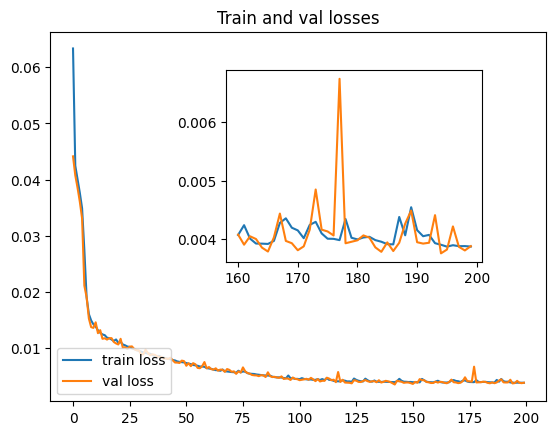

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['loss'][int(0.8*len(history['loss'])):],label='train loss')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_loss'][int(0.8*len(history['loss'])):],label='val loss')
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

Text(0.5, 1.0, 'Train and val Accs')

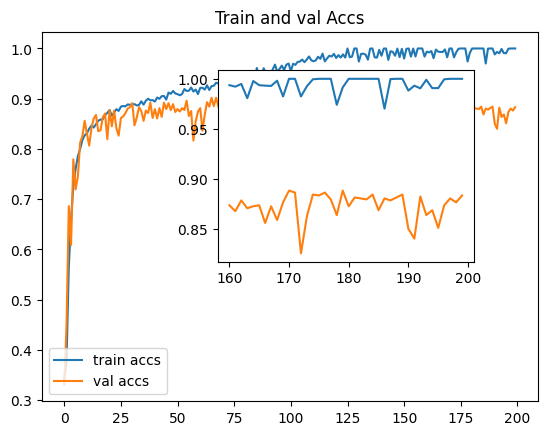

In [12]:
plot, axes = plt.subplots()
axes.plot(history['accs'],label='train accs')
axes.plot(history['val_accs'],label='val accs')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['accs'][int(0.8*len(history['loss'])):],label='train accs')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_accs'][int(0.8*len(history['loss'])):],label='val accs')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val Accs')

### Loading the best performing model

In [13]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
alpha_delta_model.load_state_dict(best_delta_weights)
print(best_val_loss)

0.003573397508886296


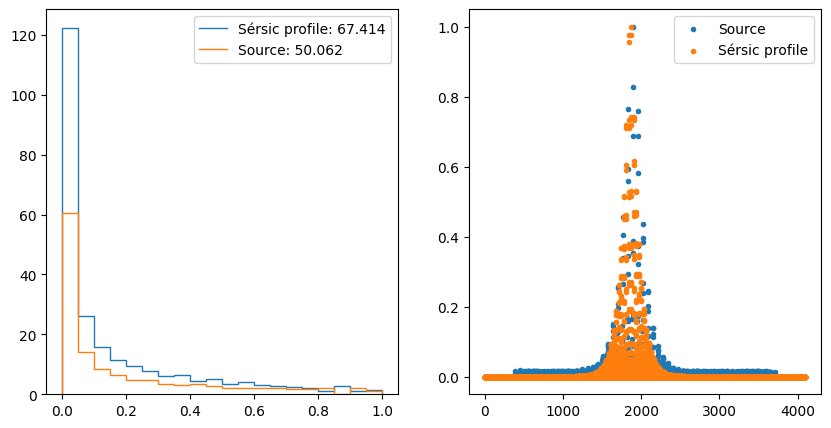

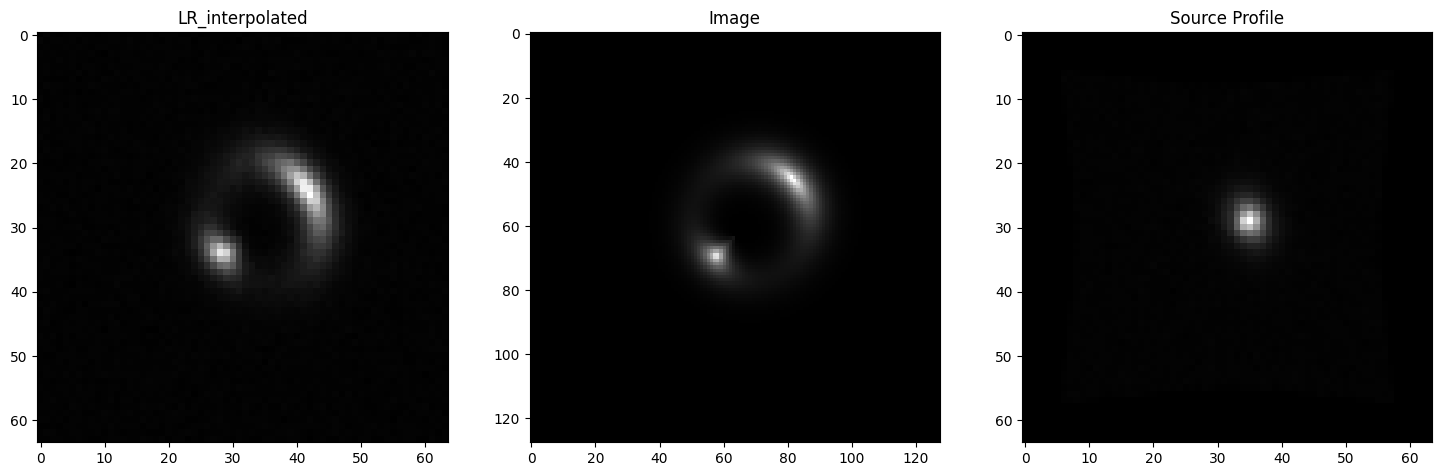

In [14]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [15]:
torch.save(best_weights, 'Weights_2.pt')
torch.save(best_delta_weights, 'Delta_2.pt')